In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import utils

In [2]:
nlp = spacy.load("en_core_web_md")

In [3]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [4]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL


In [5]:
test.head(2)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."


In [6]:
print("Number of labelled training examples: {}".format(train.shape[0]))

Number of labelled training examples: 19579


Distribution of training data for the three authors


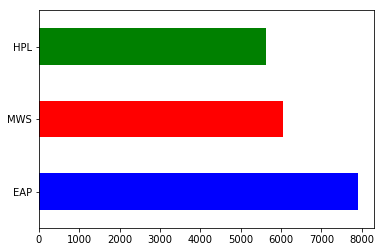

In [7]:
print("Distribution of training data for the three authors")
train['author'].value_counts().plot(kind="barh", color='brg')

In [8]:
print("Number of unlabelled test examples: {}".format(test.shape[0]))

Number of unlabelled test examples: 8392


In [9]:
# simple split for screening model performance
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.20, random_state=42)

In [68]:
# n-fold stratified CV for robust model performance
X = train
y = train.author

In [11]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [12]:
le.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [13]:
# sanity check for label ordering
# 0: EAP, 1: HPL, 2: MWS

In [14]:
y[:5]

0    EAP
1    HPL
2    EAP
3    MWS
4    HPL
Name: author, dtype: object

In [15]:
le.transform(y)[:5]

array([0, 1, 0, 2, 1])

## Author-specific Named Entities

In [16]:
ner_EAP = pd.read_csv('data/ner_EAP.csv', header=None)
ner_EAP = ner_EAP[0].tolist()
ner_HPL = pd.read_csv('data/ner_HPL.csv', header=None)
ner_HPL = ner_HPL[0].tolist()
ner_MWS = pd.read_csv('data/ner_MWS.csv', header=None)
ner_MWS = ner_MWS[0].tolist()

In [17]:
ner_EAP[:5]

['Epicurus', "Von Kempelen's", 'Underduk', 'Ellison', 'Mein Gott']

In [18]:
def kfold_CV(clf, X, y, folds, transform=True):
    """ Run a stratified k-fold Cross Validation on the training set and print the results.
        
        Args:
            clf (Pipeline): sklearn Pipeline
            X    (pandas df): data points, here: novel snippets
            y    (pandas df): class labels, here: authors
            folds      (int): number of folds
            transform (bool): if True, use .fit_transform(); if False, use .fit()
    """

    kf = StratifiedKFold(n_splits=folds, shuffle=True)
    
    precision, recall, f1 = [], [], []

    fold_cntr = 1
    for train_index, test_index in kf.split(X,y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if transform == True:
            clf.fit_transform(X_train, y_train)
        else:
            clf.fit(X_train, y_train)
        
        predicted = text_clf.predict(X_test)
        prec_, rec_, f1_ = precision_recall_fscore_support(y_test, predicted, average='macro')[:3]
        
        precision.append(prec_)
        recall.append(rec_)
        f1.append(f1_)
        
        print("FOLD: {} Precision: {}, Recall: {}, F1: {}".format(fold_cntr, round(prec_,3), round(rec_,3), round(f1_,3)))
        fold_cntr += 1
        
    print("\nAverage results of {}-fold stratified CV\n".format(folds))
    print("Precision: {}, Standard deviation: {}".format(np.mean(precision), np.std(precision)))
    print("Recall:    {}, Standard deviation: {}".format(np.mean(recall), np.std(recall)))
    print("Macro f1:  {}, Standard deviation: {}".format(np.mean(f1), np.std(f1)))

In [19]:
class DataFrameColumnExtracter(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

In [20]:
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        # print([{'length': len(text), 'num_sentences': text.count('.')} for text in posts])
        return [{'length': len(text), 'num_sentences': text.count('.')} for text in posts]

In [26]:
class NER_extractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        """The workhorse of this feature extractor"""
        ner_list = []
        for text in posts:
            doc = nlp(text)
            eap_ners = 0
            hpl_ners = 0
            mws_ners = 0
            if doc.ents:
                for ent in doc.ents:
                    if ent.text in ner_EAP:
                        eap_ners += 1
                    elif ent.text in ner_HPL:
                        hpl_ners += 1
                    elif ent.text in ner_MWS:
                        mws_ners += 1
                    
            # print({'eap_ners':eap_ners, 'hpl_ners':hpl_ners, 'mws_ner':mws_ners})
            ner_list.append({'eap_ners':eap_ners, 'hpl_ners':hpl_ners, 'mws_ner':mws_ners})
        return ner_list

In [58]:
pipeline = Pipeline([

    # Use FeatureUnion to combine the features
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text snippet
            ('text_snipped', Pipeline([
                ('selector', DataFrameColumnExtracter('text')),
                ('count_vect', CountVectorizer()),
            ])),

            # Pipeline for pulling ad hoc features text snippet
            ('text_stats', Pipeline([
                ('selector', DataFrameColumnExtracter('text')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
 
            # Pipeline for pulling NER features text snippet
            ('text_ner', Pipeline([
                ('selector', DataFrameColumnExtracter('text')),
                ('stats', NER_extractor()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        #weight components in FeatureUnion
        transformer_weights={
            'text_snippet': 1.0,
            'text_stats': 1.0,
            'text_ner': 2.0
        },
    )),

    # The machine learning algo , alpha=1
    ('clf', MultinomialNB(alpha=0.05)),
])

In [59]:
X_train_sample = X_train#.head(500)
y_train_sample = y_train#.head(500)

In [60]:
pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('text_snipped', Pipeline(steps=[('selector', <__main__.DataFrameColumnExtracter object at 0x1aad76f28>), ('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encodin...: 2.0, 'text_snippet': 1.0})), ('clf', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [61]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

        EAP       0.83      0.86      0.84      1507
        HPL       0.85      0.86      0.86      1055
        MWS       0.87      0.82      0.85      1354

avg / total       0.85      0.85      0.85      3916



In [53]:
pipeline.fit(train, y)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('text_snipped', Pipeline(steps=[('selector', <__main__.DataFrameColumnExtracter object at 0x11a8f5320>), ('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encodin...er': 2.0, 'text_snippet': 1.0})), ('clf', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))])

In [54]:
name = "bow_text_stats_ner"

In [57]:
utils.predict_for_kaggle(clf=pipeline, X=test, columns=le.classes_, ids=test.id, name=name)

,EAP,HPL,MWS
id,,,
id02310,2.013889e-03,9.450205e-05,9.978916e-01
id24541,9.999989e-01,1.085319e-06,4.892497e-08
id00134,3.983234e-03,9.960149e-01,1.886647e-06
id27757,4.382620e-01,5.617378e-01,2.533355e-07
id04081,9.719542e-01,4.984518e-03,2.306131e-02
id27337,9.472334e-01,5.267928e-02,8.732578e-05
id24265,9.827260e-01,1.042980e-02,6.844222e-03
id25917,7.111841e-04,1.542022e-03,9.977468e-01
id04951,9.999539e-01,4.604601e-05,5.408511e-09


## Logistic Regression

In [39]:
pipeline = Pipeline([

    # Use FeatureUnion to combine the features
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text snippet
            ('text_snipped', Pipeline([
                ('selector', DataFrameColumnExtracter('text')),
                ('count_vect', CountVectorizer()),
            ])),

            # Pipeline for pulling ad hoc features text snippet
            ('text_stats', Pipeline([
                ('selector', DataFrameColumnExtracter('text')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
 
            # Pipeline for pulling NER features text snippet
            ('text_ner', Pipeline([
                ('selector', DataFrameColumnExtracter('text')),
                ('stats', NER_extractor()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        #weight components in FeatureUnion
        transformer_weights={
            'text_snippet': 1.0,
            'text_stats': 1.0,
            'text_ner': 1.0
        },
    )),

    # The machine learning algo
    ('clf', LogisticRegression(C=1.0, penalty='l2', class_weight='balanced')),
])

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('text_snipped', Pipeline(steps=[('selector', <__main__.DataFrameColumnExtracter object at 0x114169278>), ('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encodin...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [41]:
pipeline.score(X_test, y_test)

0.84473953013278857

In [42]:
predicted = pipeline.predict(X_test)

In [43]:
print(classification_report(predicted, y_test))

             precision    recall  f1-score   support

        EAP       0.86      0.83      0.85      1637
        HPL       0.82      0.85      0.84      1030
        MWS       0.84      0.86      0.85      1249

avg / total       0.85      0.84      0.84      3916



In [ ]:
kfold_CV(clf=pipeline, X=X, y=y, folds=10)

## Multinomial Naive Bayes

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()),
])

In [ ]:
text_clf.fit(X_train, y_train)

In [ ]:
text_clf.score(X_test, y_test)

In [ ]:
predicted = text_clf.predict(X_test)

In [ ]:
print(classification_report(predicted, y_test))

In [ ]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10, transform=False)

## Support Vector Machine

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', SGDClassifier()),
])

In [ ]:
text_clf.fit(X_train, y_train)

In [ ]:
text_clf.score(X_test, y_test)

In [ ]:
predicted = text_clf.predict(X_test)

In [ ]:
print(classification_report(predicted, y_test))

In [ ]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10)